In [50]:
import sys
import os
workspace_path = os.path.join(os.path.abspath(".."))
sys.path.append(workspace_path)
workspace_path

'c:\\Users\\Kajsa\\VSCodeProjects\\job_discrimination'

In [51]:
import pandas as pd
from pandas.core.frame import DataFrame
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import glob
import re
import warnings
warnings.simplefilter("ignore")
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, cross_val_score, ShuffleSplit
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree, preprocessing
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import shap

# Local imports
from src.helpers import *

In [52]:
pd.options.display.float_format = "{:.2f}".format

In [53]:
path_to_cleaned_data = os.path.join(workspace_path, "data", "cleaned_data")
file_dir = os.path.join(path_to_cleaned_data, "Job_Bulletins", "labeled", "*")
file_paths = glob.glob(file_dir)

In [54]:
# Reading application statistics into dataframe
file_path = os.path.join(path_to_cleaned_data, "bulletins_w_labels_and_content.csv")
df = pd.read_csv(file_path, dtype=str)

In [55]:
df

,ID,Job Description,Apps Received,Female,Male,Unknown_Gender,File Names,Label 60/40,Numeric label 60/40,Label 70/30,Numeric label 70/30,Cleaned text,Text
0,9206,311 DIRECTOR,54,20,31,3,311 DIRECTOR 9206 041814.txt,M,2,N,0,director class code open date annual salary du...,311 DIRECTOR Class Code: 9206 Open Date:...
1,1223,ACCOUNTING CLERK,648,488,152,8,ACCOUNTING CLERK 1223 071318.txt,W,1,W,1,accounting clerk class code open date exam ope...,ACCOUNTING CLERK Class Code: 1223 Open ...
2,7260,AIRPORT MANAGER,51,13,37,1,AIRPORT MANAGER 7260 120216.txt,M,2,M,2,airport manager class code open date exam open...,AIRPORT MANAGER Class Code: 7260 Open D...
3,3227,AIRPORT POLICE LIEUTENANT,48,9,38,1,AIRPORT POLICE LIEUTENANT 3227 091616.txt,M,2,M,2,airport police lieutenant class code open date...,AIRPORT POLICE LIEUTENANT ...
4,2400,AQUARIST,40,15,24,1,AQUARIST 2400 050214.txt,M,2,N,0,aquarist class code open date annual salary ca...,AQUARIST Class Code: 2400 Open Date: 05...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
172,7840,WASTEWATER TREATMENT LABORATORY MANAGER,16,6,9,1,WASTEWATER TREATMENT LABORATORY MANAGER 7840 1...,M,2,N,0,wastewater treatment laboratory manager class ...,WASTEWATER TREATMENT LABORATORY MANAGER Class...
173,4123,WASTEWATER TREATMENT OPERATOR,125,9,113,3,WASTEWATER TREATMENT OPERATOR 120718.txt,M,2,M,2,wastewater treatment operator class code open ...,WASTEWATER TREATMENT OPERATOR Class Code: ...
174,7857,WATER MICROBIOLOGIST,179,89,82,8,WATER MICROBIOLOGIST 7857 072514 rev073114.txt,N,0,N,0,water microbiologist class code open date revi...,WATER MICROBIOLOGIST Class Code: 7857...
175,3912,WATER UTILITY WORKER,96,2,92,2,WATER UTILITY WORKER 3912 120817.txt,M,2,M,2,water utility worker class code open date exam...,WATER UTILITY WORKER Class Code: 3912 Op...


In [56]:
X = df["Cleaned text"]
y = df["Numeric label 70/30"]

In [57]:
# Initializing a vectorizer in order to transform the text to numbers

vect = TfidfVectorizer()

In [58]:
# .todense() probably not applicable in this case, since no null-values are present
X = vect.fit_transform(X).todense()

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1000)

In [60]:
model = DecisionTreeClassifier(criterion="entropy", max_depth=4)

In [61]:
model.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=4)

In [62]:
y_pred = model.predict(X_test)

In [63]:
y_pred

array(['0', '0', '0', '2', '0', '2', '0', '2', '2', '0', '0', '2', '0',
       '0', '0', '2', '0', '2', '0', '2', '0', '2', '1', '2', '2', '0',
       '2', '2', '2', '2', '1', '0', '2', '0', '2', '2', '2', '0', '2',
       '0', '2', '2', '2', '0', '0'], dtype=object)

In [64]:
accuracy = accuracy_score(y_pred, y_test) * 100
print(f"Accuracy of the model is {'{:.2f}'.format(accuracy)}")

Accuracy of the model is 64.44


In [65]:
cm = confusion_matrix(y_true=y_test, y_pred=y_pred, labels=model.classes_)

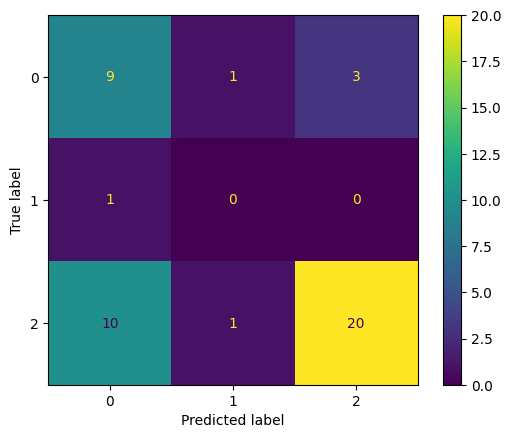

In [66]:
plot = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
plot.plot()
plt.show()

In [67]:
scores = cross_val_score(model, X, y, cv=5)
scores


array([0.69444444, 0.61111111, 0.68571429, 0.65714286, 0.68571429])

In [68]:
# Standard deviation: The spread of values. 
# High standard deviation implies high spread of accuracies between cross-validation folds
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))


0.67 accuracy with a standard deviation of 0.03


In [69]:
model.get_n_leaves()

9

In [70]:
probabilities = model.predict_proba(X_test)

In [71]:
len(probabilities)

45

In [72]:
values = zip(y_pred, probabilities)

In [73]:
for i in values:
    print(f"Prediction: {i[0]},  Probabilities: {i[1]}")

Prediction: 0,  Probabilities: [1. 0. 0.]
Prediction: 0,  Probabilities: [0.86842105 0.         0.13157895]
Prediction: 0,  Probabilities: [1. 0. 0.]
Prediction: 2,  Probabilities: [0. 0. 1.]
Prediction: 0,  Probabilities: [0.86842105 0.         0.13157895]
Prediction: 2,  Probabilities: [0. 0. 1.]
Prediction: 0,  Probabilities: [0.86842105 0.         0.13157895]
Prediction: 2,  Probabilities: [0. 0. 1.]
Prediction: 2,  Probabilities: [0. 0. 1.]
Prediction: 0,  Probabilities: [0.86842105 0.         0.13157895]
Prediction: 0,  Probabilities: [0.86842105 0.         0.13157895]
Prediction: 2,  Probabilities: [0. 0. 1.]
Prediction: 0,  Probabilities: [0.86842105 0.         0.13157895]
Prediction: 0,  Probabilities: [0.86842105 0.         0.13157895]
Prediction: 0,  Probabilities: [0.86842105 0.         0.13157895]
Prediction: 2,  Probabilities: [0. 0. 1.]
Prediction: 0,  Probabilities: [0.86842105 0.         0.13157895]
Prediction: 2,  Probabilities: [0. 0. 1.]
Prediction: 0,  Probabilitie